## Data Exploration

In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

### Load the data

In [2]:
data = pkl.load(open("data/data.pkl", "rb"))
data.head(3)

,user_id,exp_id,sch_id_1,sch_id_2,realconf,rec_time,user_sub_val,userconf,order,token_path,term_match,word_net
0,171,14,0,0,NaN,2020-12-19 12:28:13,NaN,NaN,0,NaN,NaN,NaN
1,171,14,134,180,0,2020-12-19 12:28:39,67,34,1,0.484821,0.619156,1.0
2,171,14,134,182,0,2020-12-19 12:28:45,69,38,2,0.454945,0.578095,1.0


### General statistics

Count unique values of users and attributes

In [3]:
for col in ['user_id', 'sch_id_1', 'sch_id_2']:
    unique = data[col].unique().size
    print(f"Unique values for col {col}: {unique}")

Unique values for col user_id: 181
Unique values for col sch_id_1: 27
Unique values for col sch_id_2: 20


count unique pairs (questions)

In [4]:
len(data.groupby(['sch_id_1', 'sch_id_2']))

31

Test balance between pairs that are match and pair that aren't

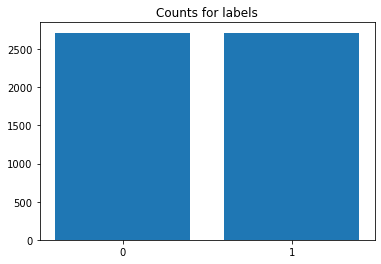

In [5]:
counts = data['realconf'].value_counts()
plt.bar(counts.index, counts.values)
plt.title("Counts for labels")
plt.xticks([0, 1], [0, 1])
plt.savefig("plots/" + plt.gcf().axes[0].get_title())
plt.show()

Users values histogram

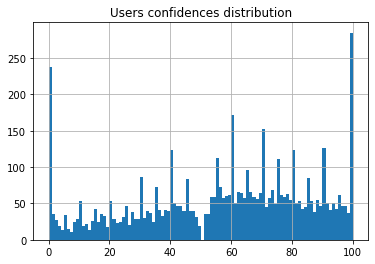

In [6]:
data['user_sub_val'].hist(bins=100)
plt.title("Users confidences distribution")
plt.savefig("plots/" + plt.gcf().axes[0].get_title())
plt.show()

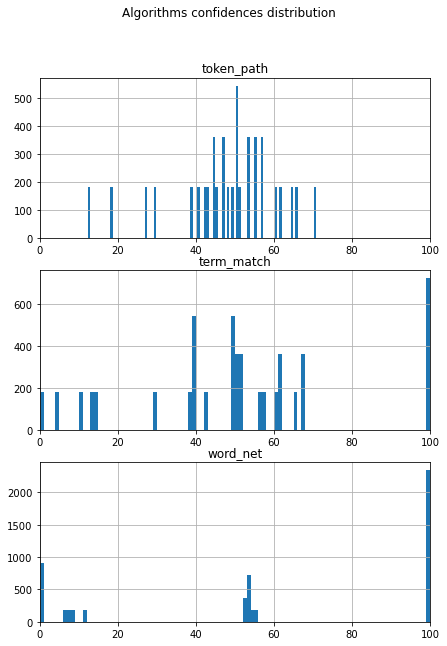

In [7]:
fig, axes = plt.subplots(3,1, figsize=(7,10))
for i,name in enumerate(["token_path","term_match","word_net"]):
    ax = axes[i]
    ax.set_title(name)
    (data[name]*100).hist(bins=100, ax=ax)
    ax.set_xlim(0,100)
plt.suptitle("Algorithms confidences distribution")
plt.savefig("plots/" + plt.gcf()._suptitle.get_text())
plt.show()

### Trends

Does the user confidence in her answer increses as the task goes on?

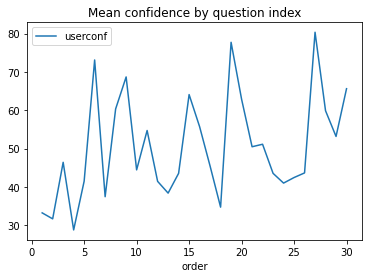

In [8]:
data[['order', 'userconf']].groupby('order').mean().plot()
plt.title("Mean confidence by question index")
plt.savefig("plots/" + plt.gcf().axes[0].get_title())
plt.show()

Does the distance between the user confidence and the GT confidence (0 / 100) decrease as the task goes on?

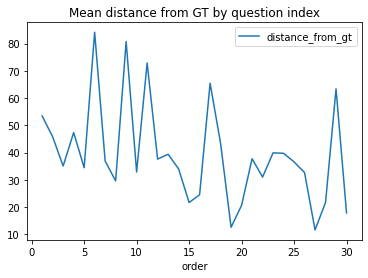

In [9]:
realconf = data['realconf']*100
data['distance_from_gt'] = (realconf - data['user_sub_val']).abs()
data.loc[data['order']==0, 'distance_from_gt'] = np.nan
data[['order', 'distance_from_gt']].groupby('order').mean().plot()
plt.title("Mean distance from GT by question index")
plt.savefig("plots/" + plt.gcf().axes[0].get_title())
plt.show()

### Users research

What is the distribution (across users) of the mean distance from the GT confidence?

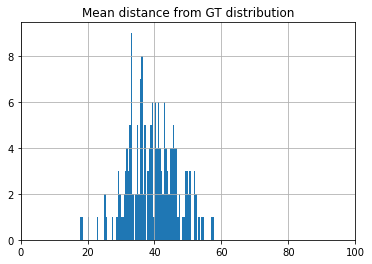

In [10]:
ax = plt.gca()
data[['user_id', "distance_from_gt"]].groupby("user_id").mean().hist(ax=ax, bins=90)
ax.set_xlim(0,100)
plt.title("Mean distance from GT distribution")
plt.savefig("plots/" + plt.gcf().axes[0].get_title())
plt.show()

What is the distribution (across users) of the correct answer percent?

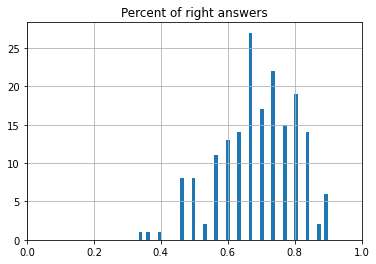

In [11]:
ax = plt.gca()
data['is_right'] = (data['realconf'] == (data['user_sub_val']>=50)).astype(int)
data.loc[data['order']==0, 'is_right'] = np.nan
data[['user_id', "is_right"]].groupby("user_id").mean().hist(ax=ax, bins=50)
ax.set_xlim(0,1)
plt.title("Percent of right answers")
plt.savefig("plots/" + plt.gcf().axes[0].get_title())
plt.show()

In [12]:
data.head(3)

,user_id,exp_id,sch_id_1,sch_id_2,realconf,rec_time,user_sub_val,userconf,order,token_path,term_match,word_net,distance_from_gt,is_right
0,171,14,0,0,NaN,2020-12-19 12:28:13,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,171,14,134,180,0,2020-12-19 12:28:39,67,34,1,0.484821,0.619156,1.0,67,0.0
2,171,14,134,182,0,2020-12-19 12:28:45,69,38,2,0.454945,0.578095,1.0,69,0.0


### High-confidence research

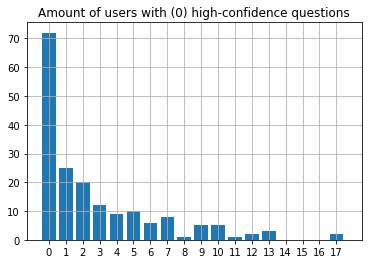

In [20]:
high_confidence_threshold = 0
t = data[['user_id']].copy()
t[f'high_confidence_{high_confidence_threshold}'] = pd.DataFrame([data['user_sub_val'], 100 - data['user_sub_val']]).min(axis=0) <= high_confidence_threshold
t.groupby('user_id').sum().reset_index()[f'high_confidence_{high_confidence_threshold}'].hist(bins=18, width=0.8)
plt.xticks(np.arange(18)+0.4, range(18))
plt.title(f"Amount of users with ({high_confidence_threshold}) high-confidence questions")
plt.savefig("plots/" + plt.gcf().axes[0].get_title())
plt.show()

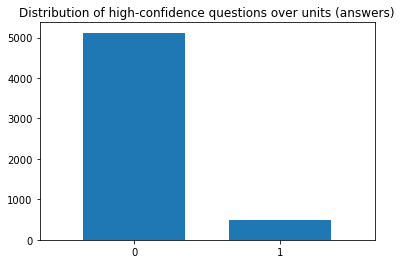

In [21]:
q = 0.35
t[f'high_confidence_{high_confidence_threshold}'].astype(int).hist(bins=[-0.5,0.5,1.5], width=2*q)
plt.title("Distribution of high-confidence questions over units (answers)")
plt.xticks(np.arange(2) - (0.5-q), [0, 1])
plt.xlim(-0.8, 1.5)
plt.grid(False)
plt.savefig("plots/" + plt.gcf().axes[0].get_title())
plt.show()

In [15]:
t = data[['user_id', 'order', 'userconf']].copy()
t['order-1'] = t['order'] - 1
t = pd.merge(t, data[['user_id', 'order', 'userconf']], how='left', left_on=['user_id', 'order-1'], right_on=['user_id', 'order'])
t = t[['user_id', 'order_x', 'userconf_x', 'userconf_y']]
t.rename(columns={'order_x':'order', 'userconf_x':'userconf', 'userconf_y':'prev_userconf'}, inplace=True)
t[['userconf', 'prev_userconf']].astype(float).corr()

,userconf,prev_userconf
userconf,1.000000,0.230245
prev_userconf,0.230245,1.000000


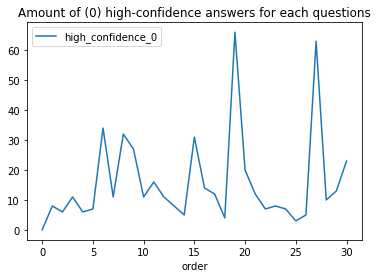

In [29]:
high_confidence_threshold = 0
t = data[['order']].copy()
t[f'high_confidence_{high_confidence_threshold}'] = pd.DataFrame([data['user_sub_val'], 100 - data['user_sub_val']]).min(axis=0) <= high_confidence_threshold
t.groupby('order').sum().plot()
plt.title(f"Amount of ({high_confidence_threshold}) high-confidence answers for each questions")
plt.savefig("plots/" + plt.gcf().axes[0].get_title())
plt.show()

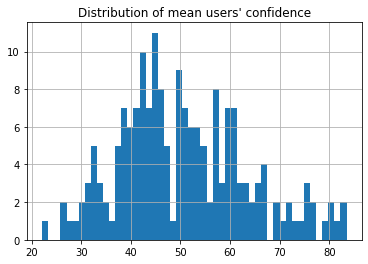

In [17]:
data[['user_id', 'userconf']].groupby('user_id').mean().hist(bins=50)
plt.title("Distribution of mean users' confidence")
plt.savefig("plots/" + plt.gcf().axes[0].get_title())
plt.show()

### Others

In [18]:
save = False
if save:
    pkl.dump(data, open("data/data.pkl", "wb"))

In [31]:
data

,user_id,exp_id,sch_id_1,sch_id_2,realconf,rec_time,user_sub_val,userconf,order,token_path,term_match,word_net,distance_from_gt,is_right
0,171,14,0,0,NaN,2020-12-19 12:28:13,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,171,14,134,180,0,2020-12-19 12:28:39,67,34,1,0.484821,0.619156,1.000000,67,0.0
2,171,14,134,182,0,2020-12-19 12:28:45,69,38,2,0.454945,0.578095,1.000000,69,0.0
3,171,14,153,183,1,2020-12-19 12:28:54,38,24,3,0.552425,0.397624,1.000000,62,0.0
4,171,14,149,180,0,2020-12-19 12:28:57,57,14,4,0.502679,0.619156,1.000000,57,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5606,711,14,164,178,1,2021-11-08 11:01:41,61,22,26,0.550549,0.493333,0.536885,39,1.0
5607,711,14,154,212,0,2021-11-08 11:01:43,89,78,27,0.294607,0.000000,0.113996,89,0.0
5608,711,14,152,182,1,2021-11-08 11:01:44,37,26,28,0.534670,0.500000,0.000000,63,0.0
5609,711,14,122,206,1,2021-11-08 11:01:46,76,52,29,0.270769,0.130476,0.072077,24,1.0
